## **Project One: TripAdvisor Recommendation Challenge - Beating BM25**
_**Authors:** Alberto MARTINELLI, Alessia SARRITZU_

### **Introduction**
The goal of this project is to develop an unsupervised recommendation system that uses user reviews to suggest similar locations, outperforming the BM25 baseline. The system is evaluated using **Mean Squared Error (MSE)** between query and recommended location ratings, focusing exclusively on review text.

### **Development Phases**
1. **Data and Libraries import**
   - Import the dataset.
   - Import the necessary libraries.
   - Initialize necessary variables and utilities.

2. **Data Preparation:**
   - Filter reviews to include only those with ratings strictly covering seven aspects: **service**, **cleanliness**, **overall**, **value**, **location**, **sleep quality**, and **rooms**.
   - Concatenate reviews by `offering_id` and compute average ratings for each aspect to represent each location.
   - Take a random sample of 100 queries from the dataset for consistent evaluation of model performance.

3. **Data Pre-Processing:**
   - Apply text preprocessing to standardize review text:
     - Tokenization: Split text into words.
     - Stop word removal: Exclude common, irrelevant words.
     - Lemmatization: Reduce words to their base forms.

4. **BM25 Implementation:**
   - Use the **Rank-BM25** library to recommend locations based on textual similarity.
   - Evaluate performance by calculating MSE between query and recommended location ratings.

5. **Enhanced Model Implementation:**
   - Create a more advanced unsupervised model to outperform BM25.
   - Use **TF-IDF vectorization** and **cosine similarity** to capture semantic relationships between reviews.

6. **Evaluation and Comparison:**
   - Compare MSE results to determine the improved performance of the enhanced model.

---

In [17]:
!pip install swifter rank-bm25
!pip install nltk
!pip install scikit-learn
!pip install matplotlib
!pip install gdown

1. **Data and Libraries Import**

In [18]:
import os
import pandas as pd
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import swifter
from rank_bm25 import BM25Okapi
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import gdown

reviews = 'reviews.csv'
output_file = "results.csv"
preprocessed_file = "final_df_preprocessed.csv"

reviews_file_id = "1rchaf8BecR3ySxfPBJ5zDo9Vf84nzaNh"
output_file_id = "1o40sWbqXARqhLxKpgiEWU3n248BlBt1T"
preprocessed_file_id = "1HcMuvQNpQE_I_NPjJ9e6qKOw_I5XVnjV"

# Download files using their IDs
gdown.download(f"https://drive.google.com/uc?id={reviews_file_id}", reviews, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={output_file_id}", output_file, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={preprocessed_file_id}", preprocessed_file, quiet=False)

print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 1. Importing data")
df = pd.read_csv(reviews)



Downloading...
From (original): https://drive.google.com/uc?id=1rchaf8BecR3ySxfPBJ5zDo9Vf84nzaNh
From (redirected): https://drive.google.com/uc?id=1rchaf8BecR3ySxfPBJ5zDo9Vf84nzaNh&confirm=t&uuid=121a2af0-e06d-4110-87c2-ef0291afdfcb
To: /content/reviews.csv
100%|██████████| 1.01G/1.01G [00:13<00:00, 77.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o40sWbqXARqhLxKpgiEWU3n248BlBt1T
To: /content/results.csv
100%|██████████| 5.25k/5.25k [00:00<00:00, 10.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HcMuvQNpQE_I_NPjJ9e6qKOw_I5XVnjV
From (redirected): https://drive.google.com/uc?id=1HcMuvQNpQE_I_NPjJ9e6qKOw_I5XVnjV&confirm=t&uuid=66a01a96-a139-4fa5-9366-e920873fbbcb
To: /content/final_df_preprocessed.csv
100%|██████████| 217M/217M [00:02<00:00, 88.7MB/s]


[2024-11-27 16:45:25] 1. Importing data


In [19]:
aspects = ["service", "cleanliness", "overall", "value", "location", "sleep_quality", "rooms"]

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---
2. **Data Preparation**

In [20]:
def dataframe_preparation(df):
    # --------------------------- Filter data --------------------------------------------
    required_aspects = {"service", "cleanliness", "overall", "value", "location", "sleep_quality", "rooms"}
    filtered_df = df[df['ratings'].apply(lambda x: set(eval(x).keys()) == required_aspects)]
    filtered_df = filtered_df.reset_index(drop=True)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]    2.1 Data filtered")

    # -------------------------- Take a sample for model testing --------------------------
    sample_df = filtered_df.sample(n=100, random_state=42)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]    2.2 Sample of 100 queries retrieved for model testing")

    # ------------------ Concatenate reviews for the same place ---------------------------
    filtered_df.loc[:, 'ratings'] = filtered_df['ratings'].apply(eval)
    expanded_ratings_df = pd.json_normalize(filtered_df['ratings']).join(filtered_df[['offering_id', 'title', 'text']])

    # Calculate the mean of each rating aspect and concatenate reviews
    final_df = expanded_ratings_df.groupby('offering_id').agg(
        service=('service', 'mean'),
        cleanliness=('cleanliness', 'mean'),
        overall=('overall', 'mean'),
        value=('value', 'mean'),
        location=('location', 'mean'),
        sleep_quality=('sleep_quality', 'mean'),
        rooms=('rooms', 'mean'),
        text=('text', lambda x: ' '.join(x)),
    ).reset_index()

    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]    2.3 Reviews concatenated")
    return sample_df, final_df

print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 2. Preparing data")
sample_df, final_df = dataframe_preparation(df)

[2024-11-27 16:45:44] 2. Preparing data
[2024-11-27 16:46:46]    2.1 Data filtered
[2024-11-27 16:46:46]    2.2 Sample of 100 queries retrieved for model testing
[2024-11-27 16:47:06]    2.3 Reviews concatenated


---
3. **Data Pre-Processing**

In [21]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

if os.path.exists(preprocessed_file):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 3. Loading preprocessed final_df")
    final_df = pd.read_csv(preprocessed_file)
else:
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 3. Preprocessing final_df")
    final_df['text'] = final_df['text'].swifter.apply(preprocess_text)
    final_df.to_csv(preprocessed_file, index=False)

[2024-11-27 16:47:06] 3. Loading preprocessed final_df


---
4. **BM25 Implementation**

In [22]:
# Query details extraction
def extract_query(query_row, aspects, df):
    query_id = query_row['offering_id']
    query_text = query_row['text']
    place_ratings = df[df['offering_id'] == query_id][aspects].iloc[0]
    return query_id, query_text, place_ratings

# BM25 implementation
def apply_bm25(query_id, query_text, place_ratings, df, aspects):
    # Exclude the query place from the documents to avoid recommending it
    documents_df = df[df['offering_id'] != query_id].reset_index(drop=True)

    # Tokenize each document for BM25
    documents_df['text'] = documents_df['text'].astype(str)
    documents = documents_df['text'].apply(lambda x: x.split())
    bm25 = BM25Okapi(documents)
    scores = bm25.get_scores(query_text.split())
    top_match_index = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[0]
    top_match = documents_df.iloc[top_match_index]

    # Calculate the MSE between the ratings of the query place and the recommended place
    recommended_ratings = top_match[aspects]
    mse = mean_squared_error(place_ratings, recommended_ratings)
    return mse

In [23]:
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 4. Processing data (BM25)")

if not os.path.exists(output_file):
    pd.DataFrame(columns=["row_id", "offering_id", "bm25_mse"]).to_csv(output_file, index=False)

existing_results = pd.read_csv(output_file)
processed_ids = set(existing_results[~existing_results["bm25_mse"].isna()]["row_id"].values)  # Exclude rows with missing bm25_mse

for index, row in sample_df.iterrows():
    # Process rows if they are not processed or have missing bm25_mse
    if index not in processed_ids or pd.isna(existing_results.loc[existing_results["row_id"] == index, "bm25_mse"].values[0]):
        query_id, query_text, place_ratings = extract_query(row, aspects, final_df)
        mse = apply_bm25(query_id, query_text, place_ratings, final_df, aspects)
        if index in existing_results["row_id"].values:
            existing_results.loc[existing_results["row_id"] == index, "bm25_mse"] = mse
        else:
            new_row = pd.DataFrame([{"row_id": index, "offering_id": query_id, "bm25_mse": mse}])
            existing_results = pd.concat([existing_results, new_row], ignore_index=True)
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]    -> Row {index}: processed with BM25 MSE={mse}")

existing_results.to_csv(output_file, index=False)
if not existing_results.empty:
    overall_average_mse = existing_results["bm25_mse"].mean()
    res = overall_average_mse
else:
    res = "No data available in the file"
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]    4.1 Calculating average MSE: {res}")


[2024-11-27 16:47:11] 4. Processing data (BM25)
[2024-11-27 16:47:11]    4.1 Calculating average MSE: 0.45813370502598055


---
5. **Enhanced Model Implementation**

In [24]:
# Enhanced model 1
def apply_EM1(query_id, query_text, place_ratings, final_df, aspects):
    # Exclude the query place from the documents to avoid recommending it
    documents_df = final_df[final_df['offering_id'] != query_id].reset_index(drop=True)

    # Combine query and documents for TF-IDF processing
    all_texts = [query_text] + documents_df['text'].fillna('').tolist()  # Replace NaN with an empty string

    # Compute TF-IDF vectors
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Compute cosine similarities between query and all documents
    query_vector = tfidf_matrix[0]
    doc_vectors = tfidf_matrix[1:]
    similarities = cosine_similarity(query_vector, doc_vectors).flatten()

    # Retrieve the top matching place based on cosine similarity
    top_match_index = np.argmax(similarities)
    top_match = documents_df.iloc[top_match_index]

    # Calculate the MSE between the ratings of the query place and the recommended place
    recommended_ratings = top_match[aspects]
    mse = mean_squared_error(place_ratings, recommended_ratings)
    return mse

In [25]:
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 5. Processing data (EM1)")
output_file = "results.csv"

# Ensure the results file exists with the required columns
if not os.path.exists(output_file):
    pd.DataFrame(columns=["row_id", "offering_id", "bm25_mse", "EM1_mse"]).to_csv(output_file, index=False)

# Load existing results
existing_results = pd.read_csv(output_file)

# Ensure 'EM1_mse' column exists
if "EM1_mse" not in existing_results.columns:
    existing_results["EM1_mse"] = None  # Add the column with default None values

# Track processed IDs for TFIDF
processed_em1_ids = set(existing_results[~existing_results["EM1_mse"].isna()]["row_id"].values)

# Iterate through the sample DataFrame
for index, row in sample_df.iterrows():
    if index not in processed_em1_ids:
        query_id, query_text, place_ratings = extract_query(row, aspects, final_df)
        em1_mse = apply_EM1(query_id, query_text, place_ratings, final_df, aspects)

        # Update the row in existing_results or append a new one
        if index in existing_results["row_id"].values:
            # Update the existing row with the new TFIDF_mse value
            existing_results.loc[existing_results["row_id"] == index, "EM1_mse"] = em1_mse
        else:
            # Append a new row if it doesn't exist
            new_row = {"row_id": index, "offering_id": query_id, "bm25_mse": None, "EM1_mse": em1_mse}
            existing_results = pd.concat([existing_results, pd.DataFrame([new_row])], ignore_index=True)

        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]    -> Row {index}: processed with EM1 MSE={em1_mse}")

# Save the updated results back to the file
existing_results.to_csv(output_file, index=False)

# Calculate and print average TFIDF MSE of the entire file
if not existing_results["EM1_mse"].isna().all():
    overall_em1_mse = existing_results["EM1_mse"].dropna().mean()
    res_em1 = overall_em1_mse
else:
    res_em1 = "No data available in the file"

print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]    5.1 Calculating average TF-IDF MSE: {res_em1}")

[2024-11-27 16:47:11] 5. Processing data (EM1)
[2024-11-27 16:47:11]    5.1 Calculating average TF-IDF MSE: 0.4356007234661014


---
6. **Evaluation and comparison**

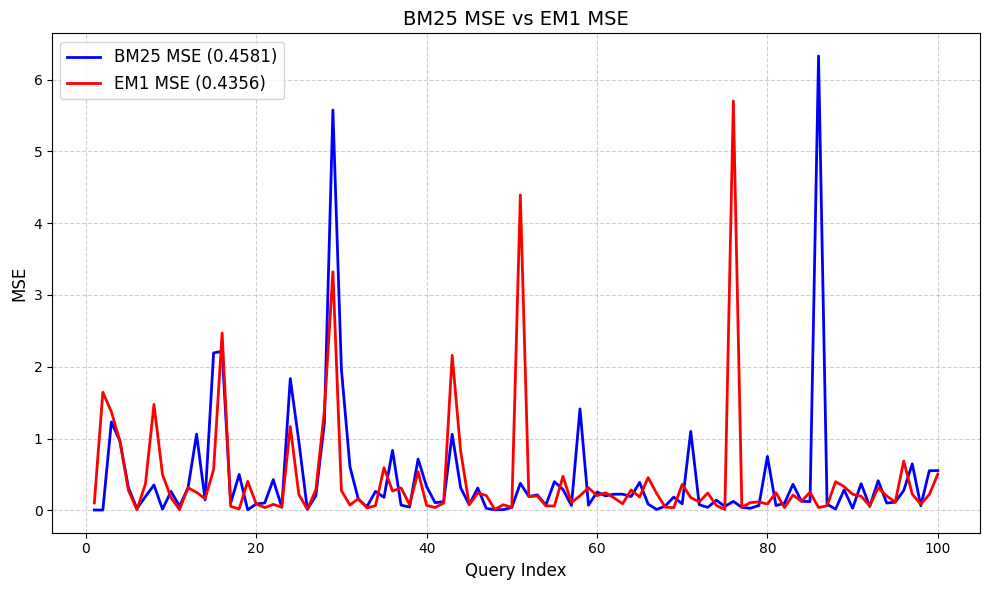

In [29]:
def analyze_models(file_name):
    data = pd.read_csv(file_name)

    plt.figure(figsize=(10, 6))
    x_ticks = range(1, len(data) + 1)
    plt.plot(x_ticks, data['bm25_mse'], label=f'BM25 MSE ({data["bm25_mse"].mean():.4f})', color='blue', linestyle='-', linewidth=2)
    plt.plot(x_ticks, data['EM1_mse'], label=f'EM1 MSE ({data["EM1_mse"].mean():.4f})', color='red', linestyle='-', linewidth=2)
    plt.xlabel('Query Index', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.title('BM25 MSE vs EM1 MSE', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

analyze_models(output_file)